# Cost-Sensitive-Classification
This notebook shows an example of cost sensitive classification using the credit card default dataset on [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/home) using [LightGBM](https://github.com/Microsoft/LightGBM). The dataset is originally from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). <br>
The response for this dataset is a binary outcome - default for next months payment. <br>
We will make up unequal costs for the errors (false positive and false negatives) on this problem and then look at 3 different ways of tackling cost sensitive classification; 
- Optimising the probability threshold
- Reweighting the training dataset
- Defining the loss function to take account of the costs <br>

The last section of the notebook shows the derivation of the loss function accounting for different costs. <br>
Note we will build basic models without any parameter tuning or variable selction and the same parameters for all models built. <br>
<br>
This notebook was inspired by this [question](https://datascience.stackexchange.com/questions/26972/cost-sensitive-logloss-for-xgboost) on stackexchange regarding cost sensitive loss function.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Cost-Sensitive-Classification" data-toc-modified-id="Cost-Sensitive-Classification-1">Cost-Sensitive-Classification</a></span><ul class="toc-item"><li><span><a href="#Get-default-of-credit-card-clients-dataset" data-toc-modified-id="Get-default-of-credit-card-clients-dataset-1.1">Get default of credit card clients dataset</a></span><ul class="toc-item"><li><span><a href="#Download-dataset-from-Kaggle" data-toc-modified-id="Download-dataset-from-Kaggle-1.1.1">Download dataset from Kaggle</a></span></li><li><span><a href="#Unzip-dataset" data-toc-modified-id="Unzip-dataset-1.1.2">Unzip dataset</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1.3">Load data</a></span></li><li><span><a href="#Define-costs-for-false-positives-and-false-negatives" data-toc-modified-id="Define-costs-for-false-positives-and-false-negatives-1.1.4">Define costs for false positives and false negatives</a></span></li><li><span><a href="#Create-weights-column" data-toc-modified-id="Create-weights-column-1.1.5">Create weights column</a></span></li><li><span><a href="#Create-sample-column" data-toc-modified-id="Create-sample-column-1.1.6">Create sample column</a></span></li><li><span><a href="#Create-LightGBM-datasets" data-toc-modified-id="Create-LightGBM-datasets-1.1.7">Create LightGBM datasets</a></span><ul class="toc-item"><li><span><a href="#Split-out-columns-for-different-samples" data-toc-modified-id="Split-out-columns-for-different-samples-1.1.7.1">Split out columns for different samples</a></span></li><li><span><a href="#Create-equal-weighted-dataset" data-toc-modified-id="Create-equal-weighted-dataset-1.1.7.2">Create equal weighted dataset</a></span></li><li><span><a href="#Create-reweighted-dataset" data-toc-modified-id="Create-reweighted-dataset-1.1.7.3">Create reweighted dataset</a></span></li></ul></li></ul></li><li><span><a href="#Method-1:-Optimise-probability-threshold" data-toc-modified-id="Method-1:-Optimise-probability-threshold-1.2">Method 1: Optimise probability threshold</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-1.2.1">Build model</a></span></li><li><span><a href="#Get-predictions" data-toc-modified-id="Get-predictions-1.2.2">Get predictions</a></span></li><li><span><a href="#Define-evaluation-functions" data-toc-modified-id="Define-evaluation-functions-1.2.3">Define evaluation functions</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-1.2.4">Evaluate model</a></span></li></ul></li><li><span><a href="#Method-2:-Reweight-training-data" data-toc-modified-id="Method-2:-Reweight-training-data-1.3">Method 2: Reweight training data</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-1.3.1">Build model</a></span></li><li><span><a href="#Get-predictions" data-toc-modified-id="Get-predictions-1.3.2">Get predictions</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-1.3.3">Evaluate model</a></span></li></ul></li><li><span><a href="#Method-3:-Cost-sensitive-loss-function" data-toc-modified-id="Method-3:-Cost-sensitive-loss-function-1.4">Method 3: Cost sensitive loss function</a></span><ul class="toc-item"><li><span><a href="#Define-cost-sensitive-loss-function" data-toc-modified-id="Define-cost-sensitive-loss-function-1.4.1">Define cost sensitive loss function</a></span></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-1.4.2">Build model</a></span></li><li><span><a href="#Get-predictions" data-toc-modified-id="Get-predictions-1.4.3">Get predictions</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-1.4.4">Evaluate model</a></span></li></ul></li><li><span><a href="#Derivation-of-first-and-second-derivatives-for-log-loss-function" data-toc-modified-id="Derivation-of-first-and-second-derivatives-for-log-loss-function-1.5">Derivation of first and second derivatives for log loss function</a></span><ul class="toc-item"><li><span><a href="#Log-loss-derivation" data-toc-modified-id="Log-loss-derivation-1.5.1">Log loss derivation</a></span></li><li><span><a href="#Cost-sensitive-loss-derivation" data-toc-modified-id="Cost-sensitive-loss-derivation-1.5.2">Cost sensitive loss derivation</a></span></li></ul></li></ul></li></ul></div>

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import metrics
import os
import zipfile
import warnings
import sklearn.exceptions
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 50)

This disables warnings from sklearn's metrics for when we calculate classification metrics across many threshold and get no examples positively classified.

In [3]:
warnings.filterwarnings("ignore", category = sklearn.exceptions.UndefinedMetricWarning)

Setting the KMP_DUPLICATE_LIB_OK environment variable is to prevent the following error; "OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized." See https://github.com/dmlc/xgboost/issues/1715 for a discussion on the problem.

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Get default of credit card clients dataset

### Download dataset from Kaggle

In [4]:
os.system('kaggle datasets download -d uciml/default-of-credit-card-clients-dataset')

0

### Unzip dataset

In [5]:
zip_ref = zipfile.ZipFile(os.getcwd() + '/default-of-credit-card-clients-dataset.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

In [6]:
dataset = os.getcwd() + '/UCI_Credit_Card.csv'

### Load data

See below for a description of the dataset from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#; <br>
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. <br>
X2: Gender (1 = male; 2 = female). <br>
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). <br>
X4: Marital status (1 = married; 2 = single; 3 = others). <br>
X5: Age (year). <br>
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. <br>
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. <br>
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. <br>

In [7]:
credit_card = pd.read_csv(dataset)

In [8]:
credit_card.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [9]:
credit_card.shape

(30000, 25)

In [11]:
credit_card['default.payment.next.month'].value_counts(dropna = False) / credit_card.shape[0]

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

### Define costs for false positives and false negatives
Now introduce different costs for different errors. Let's say that the cost matrix is the following, i.e. the cost of a false negative is 10 times the cost of a false positive.

In [12]:
fraud_cost_matrix = np.array([[0, 1], [10, 0]])
fraud_cost_matrix

array([[ 0,  1],
       [10,  0]])

In [13]:
tn_cost, fp_cost, fn_cost, tp_cost = fraud_cost_matrix.ravel()
tn_cost, fp_cost, fn_cost, tp_cost

(0, 1, 10, 0)

### Create weights column

In [14]:
credit_card['weights'] = 0

In [15]:
credit_card.loc[credit_card['default.payment.next.month'] == 0, 'weights'] = fp_cost

In [16]:
credit_card.loc[credit_card['default.payment.next.month'] == 1, 'weights'] = fn_cost

### Create sample column

In [17]:
np.random.seed(1)

In [18]:
credit_card['samp'] = np.random.randint(low = 0, high = 6, size = credit_card.shape[0])

In [19]:
credit_card['samp'].value_counts().sort_index()

0    5068
1    4941
2    5047
3    5015
4    4860
5    5069
Name: samp, dtype: int64

### Create LightGBM datasets

In [20]:
weights_col = 'weights'

In [21]:
response_col = 'default.payment.next.month'

In [22]:
not_explanatory_cols = [response_col, weights_col] + \
                       ['ID', 'samp'] 

In [23]:
explanatory_cols = list(set(credit_card.columns.values) - set(not_explanatory_cols))
explanatory_cols.sort()
len(explanatory_cols)

23

#### Split out columns for different samples

In [24]:
train_expl = credit_card.loc[credit_card.samp < 4, explanatory_cols]
val_expl = credit_card.loc[credit_card.samp == 4, explanatory_cols]
test_expl = credit_card.loc[credit_card.samp == 5, explanatory_cols]

In [25]:
train_expl.dtypes

AGE            int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
EDUCATION      int64
LIMIT_BAL    float64
MARRIAGE       int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
SEX            int64
dtype: object

In [26]:
train_w = credit_card.loc[credit_card.samp < 4, weights_col]
val_w = credit_card.loc[credit_card.samp == 4, weights_col]
test_w = credit_card.loc[credit_card.samp == 5, weights_col]

In [27]:
train_resp = credit_card.loc[credit_card.samp < 4, response_col]
val_resp = credit_card.loc[credit_card.samp == 4, response_col]
test_resp = credit_card.loc[credit_card.samp == 5, response_col]

#### Create equal weighted dataset

In [28]:
lgb_train = lgb.Dataset(data = train_expl, label = train_resp)
lgb_val = lgb.Dataset(data = val_expl, label = val_resp)
lgb_test = lgb.Dataset(data = test_expl, label = test_resp)

#### Create reweighted dataset
This will be used for the second model.

In [29]:
lgb_train_w = lgb.Dataset(data = train_expl, label = train_resp, weight = train_w)
lgb_val_w = lgb.Dataset(data = val_expl, label = val_resp, weight = val_w)
lgb_test_w = lgb.Dataset(data = test_expl, label = test_resp, weight = test_w)

## Method 1: Optimise probability threshold
This method adjusts the classification threshold of the models based off the costs for the problem

### Build model

In [30]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

In [31]:
evals_result_1 = {}

In [32]:
gbm_1 = lgb.train(params,
                  lgb_train,
                  num_boost_round = 100,
                  early_stopping_rounds = 5,
                  valid_sets = [lgb_train, lgb_val],
                  verbose_eval = False,
                  evals_result = evals_result_1)

best iteration: 68


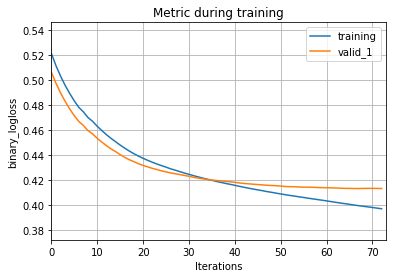

In [33]:
print('best iteration:', gbm_1.best_iteration)
lgb.plotting.plot_metric(evals_result_1)

### Get predictions

In [34]:
val_pred = gbm_1.predict(val_expl, num_iteration = gbm_1.best_iteration)

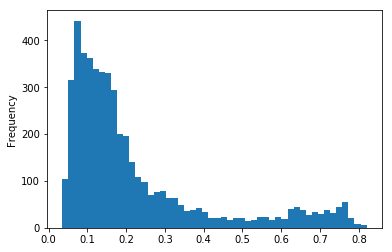

In [35]:
pd.Series(val_pred).plot('hist', bins = 50)

### Define evaluation functions
Will be used for the other models too

In [36]:
def classification_metrics(y_true, y_pred, cost_matrix = np.array([[0, 1], [1, 0]])):
    """Function to calculate various classification metrics"""
    
    confussion_matrix = metrics.confusion_matrix(y_true, y_pred)

    m = {}
    m['accuracy'] = metrics.accuracy_score(y_true, y_pred)
    m['balanced_accuracy'] = metrics.balanced_accuracy_score(y_true, y_pred)
    m['brier_score'] = metrics.brier_score_loss(y_true, y_pred)
    m['precision'] = metrics.precision_score(y_true, y_pred)
    m['recall'] = metrics.recall_score(y_true, y_pred)
    m['f1_score'] = metrics.f1_score(y_true, y_pred)
    m['roc_auc'] = metrics.roc_auc_score(y_true, y_pred)
    m['cost'] = np.multiply(cost_matrix, confussion_matrix).sum()
    
    return(m, confussion_matrix)    

In [37]:
def cutoff_cost_curve(y_true, y_pred, cost_matrix):
    """Function to loop through 100 different probability cut off and calculate the cost for each one"""
    
    costs = pd.DataFrame(columns = ['cutoff', 'cost'])
    
    for i in np.linspace(0, 1, 101):
        eval_metrics, confussion_mat = classification_metrics(y_true, y_pred > float(i), cost_matrix)
        costs = costs.append(pd.DataFrame({'cutoff': i, 'cost': eval_metrics['cost']}, index = [i]))
        
    return(costs)

### Evaluate model

In [38]:
m, conf_mat = classification_metrics(y_true = val_resp, y_pred = val_pred > 0.5, cost_matrix = fraud_cost_matrix)

In [39]:
m

{'accuracy': 0.8292181069958847,
 'balanced_accuracy': 0.6613776061940606,
 'brier_score': 0.17078189300411523,
 'cost': 6662,
 'f1_score': 0.47864321608040195,
 'precision': 0.6767317939609236,
 'recall': 0.37026239067055394,
 'roc_auc': 0.6613776061940606}

In [40]:
conf_mat

array([[3649,  182],
       [ 648,  381]])

In [41]:
val_costs = cutoff_cost_curve(y_true = val_resp, y_pred = val_pred, cost_matrix = fraud_cost_matrix)

      cutoff  cost
0.09    0.09  3272


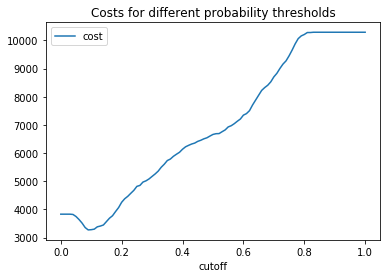

In [42]:
print(val_costs.loc[val_costs.cost == val_costs.cost.min()])
val_costs.plot(x = 'cutoff', y = 'cost', title = 'Costs for different probability thresholds')

Note the optimium cutoff, based off costs for the errors, is far from the cutoff of 0.5.

In [67]:
m, conf_mat = classification_metrics(y_true = val_resp, y_pred = val_pred > 0.09, cost_matrix = fraud_cost_matrix)

In [68]:
m

{'accuracy': 0.4082304526748971,
 'balanced_accuracy': 0.6090037312609349,
 'brier_score': 0.5917695473251029,
 'cost': 3272,
 'f1_score': 0.4065208419314899,
 'precision': 0.2580560649724915,
 'recall': 0.9572400388726919,
 'roc_auc': 0.6090037312609349}

In [69]:
conf_mat

array([[ 999, 2832],
       [  44,  985]])

## Method 2: Reweight training data
This method reweights observations in the training dataset according to the costs for the different errors. The default records have been given a higher weight so errors are penalised more in training.

### Build model

In [43]:
evals_result_2 = {}

In [44]:
gbm_2 = lgb.train(params,
                  lgb_train_w,
                  num_boost_round = 100,
                  early_stopping_rounds = 5,
                  valid_sets = [lgb_train_w, lgb_val_w],
                  verbose_eval = False,
                  evals_result = evals_result_2)

best iteration: 53


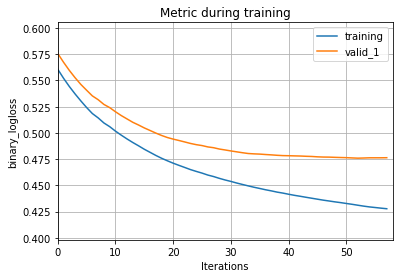

In [45]:
print('best iteration:', gbm_2.best_iteration)
lgb.plotting.plot_metric(evals_result_2)

### Get predictions

In [46]:
val_pred_2 = gbm_2.predict(val_expl, num_iteration = gbm_2.best_iteration)

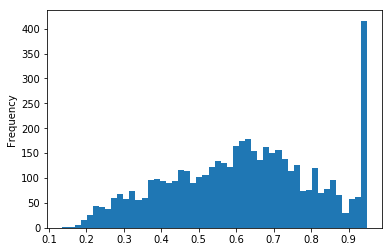

In [47]:
pd.Series(val_pred_2).plot('hist', bins = 50)

### Evaluate model

In [48]:
m2, conf_mat2 = classification_metrics(y_true = val_resp, y_pred = val_pred_2 > 0.5, cost_matrix = fraud_cost_matrix)

In [49]:
m2

{'accuracy': 0.46255144032921813,
 'balanced_accuracy': 0.6306652877058643,
 'brier_score': 0.5374485596707819,
 'cost': 3332,
 'f1_score': 0.4208425720620843,
 'precision': 0.27262280953748924,
 'recall': 0.9222546161321672,
 'roc_auc': 0.6306652877058643}

In [50]:
conf_mat2

array([[1299, 2532],
       [  80,  949]])

In [51]:
val_costs_2 = cutoff_cost_curve(y_true = val_resp, y_pred = val_pred_2, cost_matrix = fraud_cost_matrix)

      cutoff  cost
0.51    0.51  3321


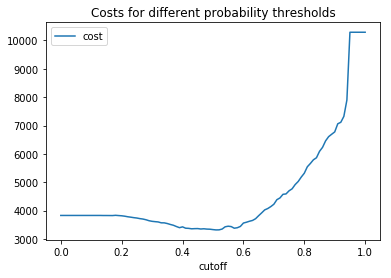

In [52]:
print(val_costs_2.loc[val_costs_2.cost == val_costs_2.cost.min()])
val_costs_2.plot(x = 'cutoff', y = 'cost', title = 'Costs for different probability thresholds')

Notice that the optimium cutoff is much closer to 0.5 now that the dataset has been balanced.

In [64]:
m2, conf_mat2 = classification_metrics(y_true = val_resp, y_pred = val_pred_2 > 0.51, cost_matrix = fraud_cost_matrix)

In [65]:
m2

{'accuracy': 0.4740740740740741,
 'balanced_accuracy': 0.6361971122490835,
 'brier_score': 0.5259259259259259,
 'cost': 3321,
 'f1_score': 0.42484248424842486,
 'precision': 0.27642752562225475,
 'recall': 0.9173955296404276,
 'roc_auc': 0.6361971122490835}

In [66]:
conf_mat2

array([[1360, 2471],
       [  85,  944]])

## Method 3: Cost sensitive loss function
In this method we optimise a different loss function which accounts for the cost differences for our data. <br>
The derivation for loss function is shown in the last section of the notebook.

### Define cost sensitive loss function
First define the cost function, it must return the first and second derivates - this is required by LightGBM to optimise a custom loss function. <br>
See https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py#L140 for an exmaple of log loss defined in this way.

Plugging the values of $\lambda = 10$ (relative false negative weight) and $\mu = 1$ (relative false positive weight) into the first and second derivate equations at the bottom of the notebook result in the following formulas; <br>
$$\frac{\partial L}{\partial X} = 9py + p - 10y$$ <br>
$$\frac{\partial^{2} L}{\partial X^{2}} = (9y +1)(1 - p)p$$ <br>
These are implemented below;

In [53]:
def cost_sensitive_loss(y_hat, dtrain):
    """Cost sensitive loss function to account for different costs for different errors"""
    y = dtrain.get_label()
    p = 1. / (1. + np.exp(-y_hat))
    grad = (9 * p * y) + p - (10 * y)
    hess = ((9 * y) + 1) * (p * (1.0 - p))
    return grad, hess

### Build model

In [54]:
evals_result_3 = {}

In [55]:
gbm_3 = lgb.train(params,
                  lgb_train,
                  num_boost_round = 100,
                  early_stopping_rounds = 5,
                  fobj = cost_sensitive_loss,
                  valid_sets = [lgb_train, lgb_val], 
                  verbose_eval = False,
                  evals_result = evals_result_3)

best iteration: 6


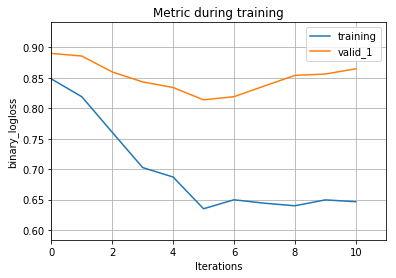

In [56]:
print('best iteration:', gbm_3.best_iteration)
lgb.plotting.plot_metric(evals_result_3)

### Get predictions

In [57]:
val_pred_3 = gbm_3.predict(val_expl, num_iteration = gbm_3.best_iteration) 

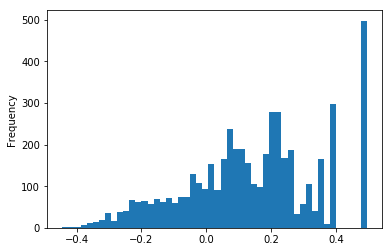

In [58]:
pd.Series(val_pred_3).plot('hist', bins = 50)

### Evaluate model

In [59]:
m3, conf_mat3 = classification_metrics(y_true = val_resp, y_pred = val_pred_3 > 0.5, cost_matrix = fraud_cost_matrix)

In [60]:
m3

{'accuracy': 0.7882716049382716,
 'balanced_accuracy': 0.5,
 'brier_score': 0.21172839506172839,
 'cost': 10290,
 'f1_score': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'roc_auc': 0.5}

In [61]:
conf_mat3

array([[3831,    0],
       [1029,    0]])

In [62]:
val_costs_3 = cutoff_cost_curve(y_true = val_resp, y_pred = val_pred_3, cost_matrix = fraud_cost_matrix)

      cutoff  cost
0.02    0.02  3375


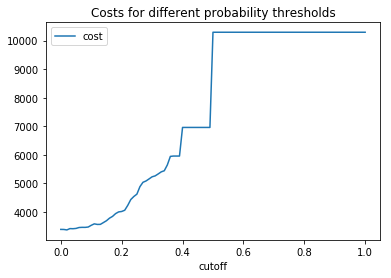

In [63]:
print(val_costs_3.loc[val_costs_3.cost == val_costs_3.cost.min()])
val_costs_3.plot(x = 'cutoff', y = 'cost', title = 'Costs for different probability thresholds')

Notice that the optimium cutoff is much closer to 0.5 now that the dataset has been balanced.

In [70]:
m3, conf_mat3 = classification_metrics(y_true = val_resp, y_pred = val_pred_3 > 0.02, cost_matrix = fraud_cost_matrix)

In [71]:
m3

{'accuracy': 0.44074074074074077,
 'balanced_accuracy': 0.6193185407063597,
 'brier_score': 0.5592592592592592,
 'cost': 3375,
 'f1_score': 0.41295896328293735,
 'precision': 0.2654818106081644,
 'recall': 0.9290573372206026,
 'roc_auc': 0.6193185407063597}

In [72]:
conf_mat3

array([[1186, 2645],
       [  73,  956]])

## Derivation of first and second derivatives for log loss function

### Log loss derivation

First define the loss function as follows;

\begin{equation}
Loss = -y log(p) - (1 - y)log(1 - p)
\end{equation}

This is made up of the sum of false negative and false positive errors;

\begin{equation}
FN = y log(p) \\
FP = (1 - y)log(1 - p) 
\end{equation}

p is given by the following;

\begin{equation}
p = \frac{1}{1 + e^{-X}}
\end{equation}

The derivative of p (will need it later) is as follows;

\begin{equation}
\frac{\partial p}{\partial X} = \frac{-1}{(1 + e^{-X})^{2}} \frac{\partial (1 + e^{-X})}{\partial X} \\
= \frac{-1}{(1 + e^{-X})^{2}} -e^{-x} \\
= \frac{e^{-x}}{(1 + e^{-X})^{2}}
\end{equation}

Similarly, 1 - p is defined as;

\begin{equation}
1- p = 1 - \frac{1}{1 + e^{-X}} \\
= \frac{1 + e^{-X} - 1}{1 + e^{-X}} \\
= \frac{e^{-X}}{1 + e^{-X}} 
\end{equation}

And it's derivative;

\begin{equation}
\frac{\partial (1 - p)}{\partial X} = -\frac{\partial p}{\partial X} \\
= -\frac{e^{-X}}{1 + e^{-X}} 
\end{equation}

We can rearrange the loss function to;

\begin{equation}
-Loss = FN + FP
\end{equation}

Then the first derivative becomes;

\begin{equation}
-\frac{\partial Loss}{\partial X} = \frac{\partial FN}{\partial X} + \frac{\partial FP}{\partial X}
\end{equation}

The derivative of the false negative element is as follows;

\begin{equation}
\frac{\partial FN}{\partial X} = y \frac{\partial log(p)}{\partial X} \\
= y \frac{\partial log(p)}{\partial p} \frac{\partial p}{\partial X} \\
= y \frac{1}{p} \frac{\partial p}{\partial X} \\
= y \frac{1}{p} \frac{e^{-X}}{(1 + e^{-X})^{2}} \\
= y \frac{1 + e^{-X}}{1} \frac{e^{-X}}{(1 + e^{-X})^{2}} \\
= \frac{y e^{-X}}{1 + e^{-X}}
\end{equation}

And the derivative of the false positive element;

\begin{equation}
\frac{\partial FP}{\partial X} = (1 - y) \frac{\partial log(1 - p)}{\partial X} \\
= (1 - y) \frac{1}{1 - p} \frac{\partial (1 - p)}{\partial X} \\
= (1 - y) \frac{1 + e^{-X}}{e^{-X}} \frac{-e^{-X}}{(1 + e^{-X})^{2}} \\
= \frac{-(1 - y)}{1 + e^{-X}}
\end{equation}

Bring the two components together for the first derivative of the loss;

\begin{equation}
-\frac{\partial Loss}{\partial X} = \frac{\partial FN}{\partial X} + \frac{\partial FP}{\partial X} \\
= \frac{y e^{-X}}{1 + e^{-X}} - \frac{(1 - y)}{1 + e^{-X}} \\
= \frac{y(e^{-X} + 1) - 1}{1 + e^{-X}} \\
= y - p
\end{equation}

Finally;

\begin{equation}
\frac{\partial Loss}{\partial X} = p - y
\end{equation}

Now for the second derivative;

\begin{equation}
\frac{\partial^{2} Loss}{\partial X^{2}} = \frac{\partial (p - y)}{\partial X} = \frac{\partial p}{\partial X} \\
= \frac{e^{-X}}{(1 + e^{-X})^{2}} \\
= \frac{1}{1 + e^{-X}} \frac{e^{-X}}{1 + e^{-X}} 
\end{equation}

These elements can be seen as p and (1 - p) respectively;

\begin{equation}
\frac{\partial^{2} Loss}{\partial X^{2}} = p(1 - p)
\end{equation}

These equations for the first and second derivates of the loss function can be seen implemented here; https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py#L140.

### Cost sensitive loss derivation

Now define the cost sensitive loss function as;

\begin{equation}
-Loss = \lambda FN + \mu FP
\end{equation}

The first derivative is as follows;

\begin{equation}
-\frac{\partial Loss}{\partial X} = \lambda \frac{\partial FN}{\partial X} + \mu \frac{\partial FP}{\partial X} \\
= \lambda \frac{y e^{-X}}{1 + e^{-X}} + \mu \frac{-(1 - y)}{1 + e^{-X}} \\
= \frac{\lambda y e^{-X} - \mu + \mu y}{1 + e^{-X}} \\
= \lambda y e^{-X} p - \mu p + \mu y p
\end{equation}

Note that;

\begin{equation}
p = \frac{1}{1 + e^{-X}}
\end{equation}

Therefore;

\begin{equation}
e^{-X} = \frac{1 - p}{p}
\end{equation}

So;

\begin{equation}
-\frac{\partial Loss}{\partial X} = \lambda y p \frac{1 - p}{p} - \mu p + \mu y p \\
= \lambda y (1 - p) - \mu p + \mu y p \\
= \lambda y - \lambda y p - \mu p + \mu y p \\
= \lambda y - \mu p + y p (\mu - \lambda) 
\end{equation}

Hence;

\begin{equation}
\frac{\partial Loss}{\partial X} = \mu p - \lambda y + y p (\lambda - \mu) 
\end{equation}

Now the second derivative is;

\begin{equation}
\frac{\partial^{2} Loss}{\partial X^{2}} = \frac{\partial (\mu p - \lambda y + y p (\lambda - \mu))}{\partial X} \\
= \mu \frac{\partial p}{\partial X} + (\lambda - \mu) y \frac{\partial p}{\partial X} \\
= (\mu + \lambda y - \mu y) \frac{\partial p}{\partial X} \\
= (\mu + \lambda y - \mu y) \frac{e^{-x}}{(1 + e^{-X})^{2}} \\
= (\mu + \lambda y - \mu y) e^{-x} p^{2} \\
= (\mu + \lambda y - \mu y) \frac{1 - p}{p} p^{2} \\
= (\mu + \lambda y - \mu y) (1 - p)p 
\end{equation}